In [267]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [268]:
df = pd.read_csv('flights_weather_df.csv')


In [270]:
print((df.arrival_delay > 0).sum() / df.shape[0])
print((df.arrival_delay_categorised > 0).sum() / df.shape[0])

0.34005377543104726
0.18527181643458587


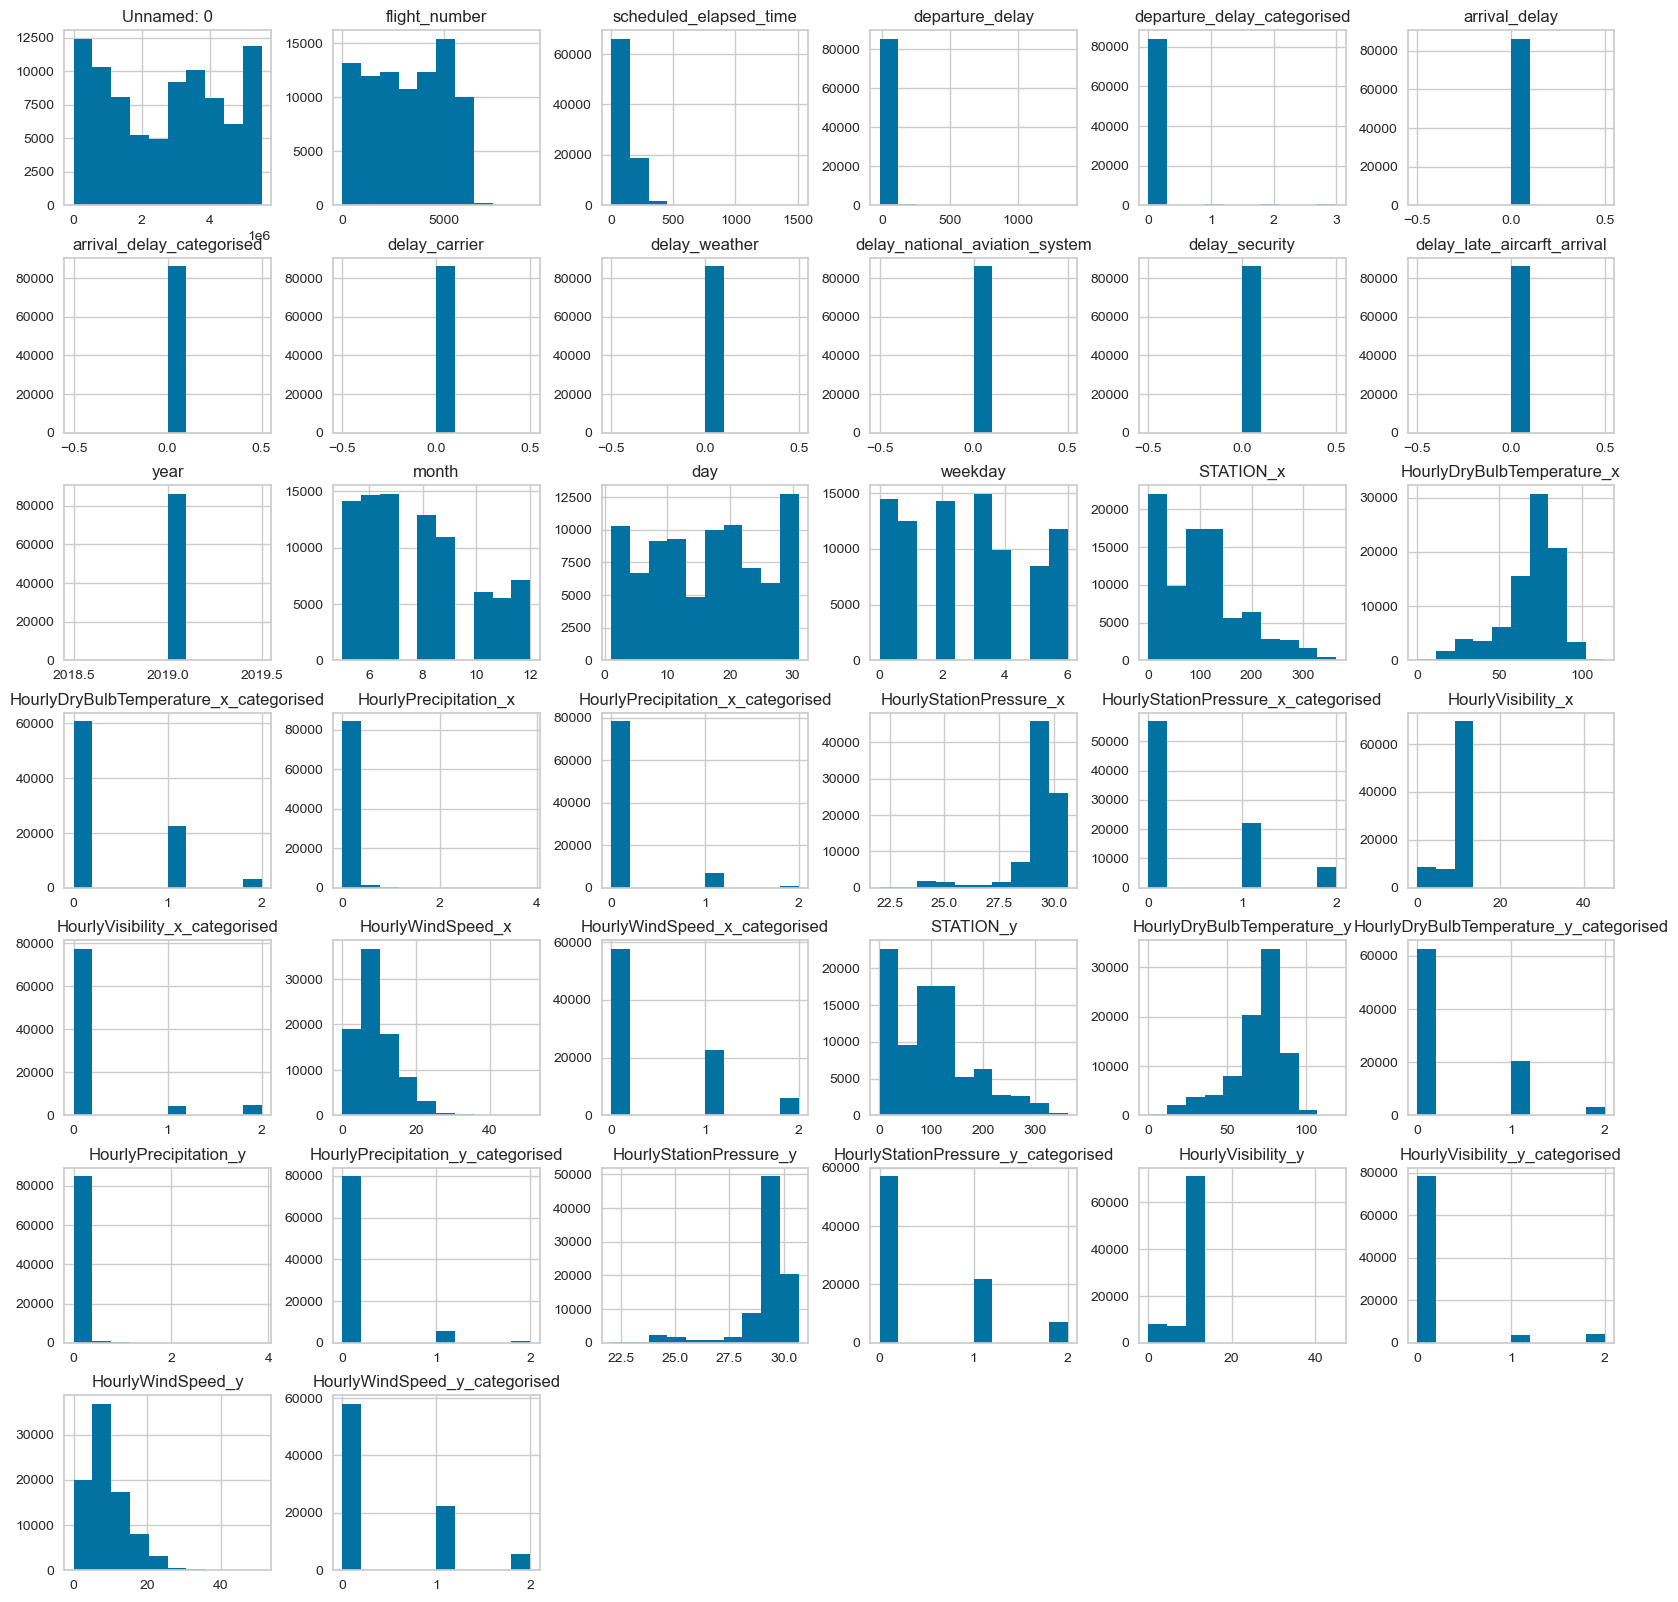

In [271]:
df_cancel = df[df.cancelled_code != "N"]
df_cancel.hist(figsize=(20,20)); 

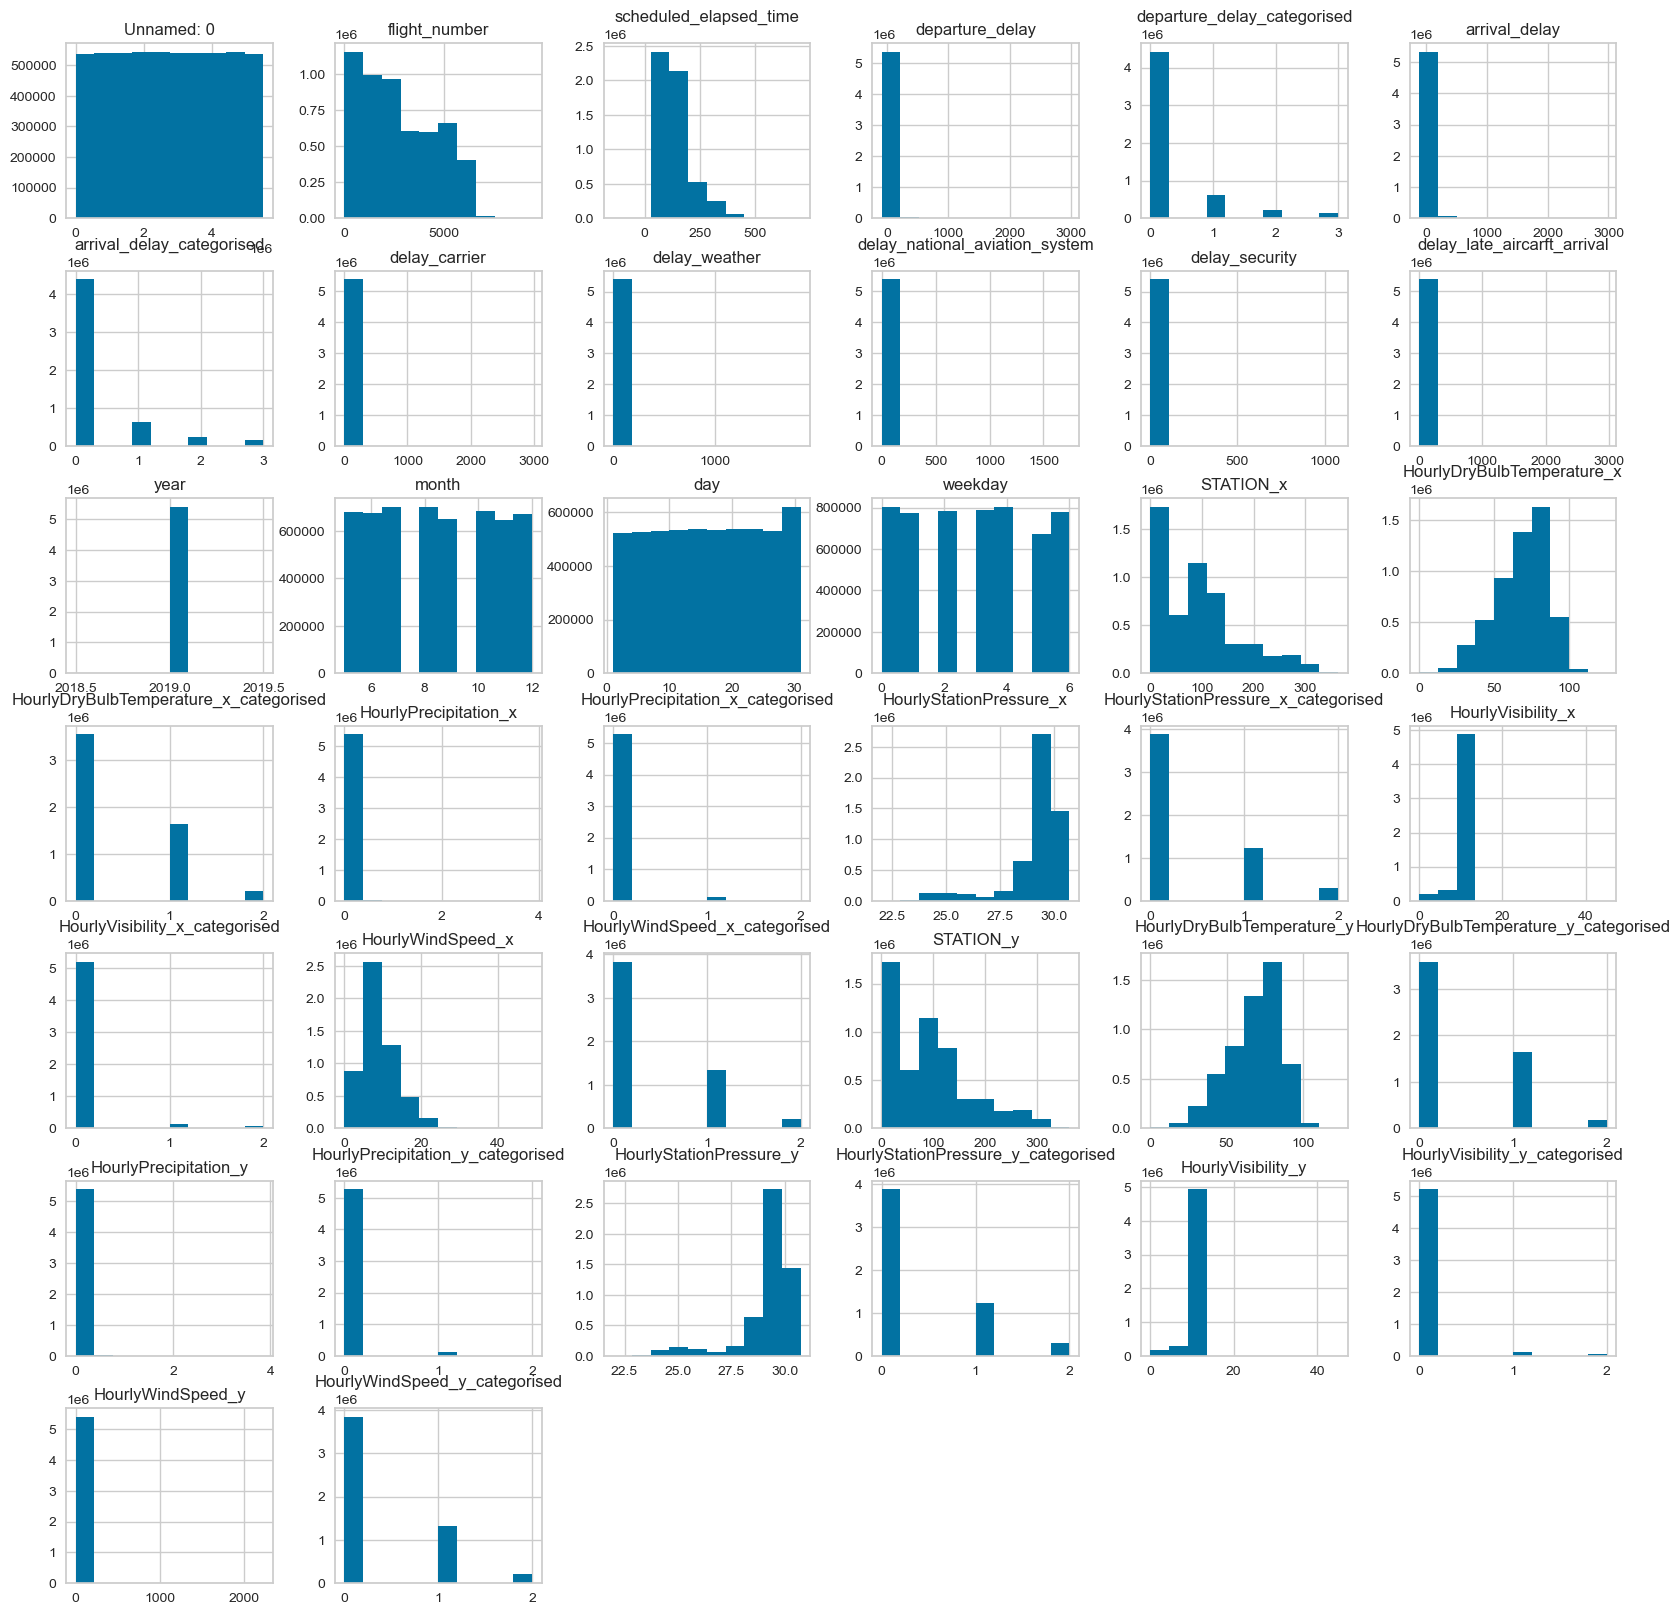

In [272]:
df_nocancel = df[df.cancelled_code == "N"]
df_nocancel = df_nocancel[df_nocancel['HourlyWindSpeed_x'] <= 500]
df_nocancel.hist(figsize=(20,20)); 

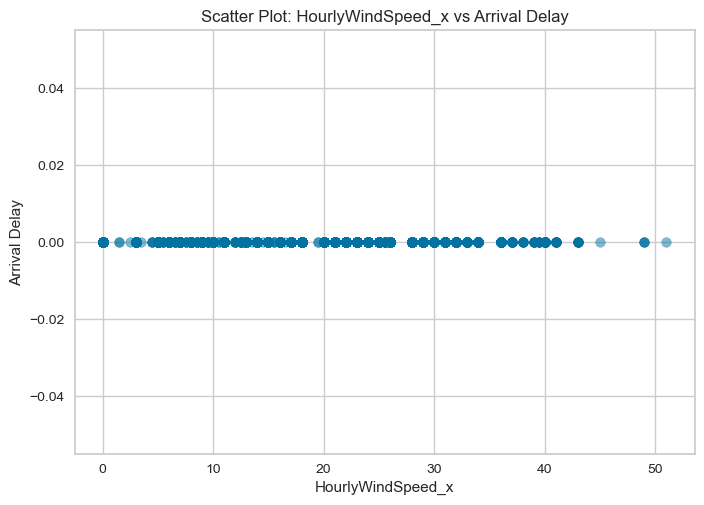

In [273]:
x_values = df_cancel['HourlyWindSpeed_x']
y_values = df_cancel['arrival_delay']

# Create a scatter plot
plt.scatter(x_values, y_values, alpha=0.5)  # alpha sets the transparency of points

# Set labels and title
plt.xlabel('HourlyWindSpeed_x')
plt.ylabel('Arrival Delay')
plt.title('Scatter Plot: HourlyWindSpeed_x vs Arrival Delay')

# Show the plot
plt.show()

It can be seen that when the flight is cancelled, there are no delays because the flight never took place

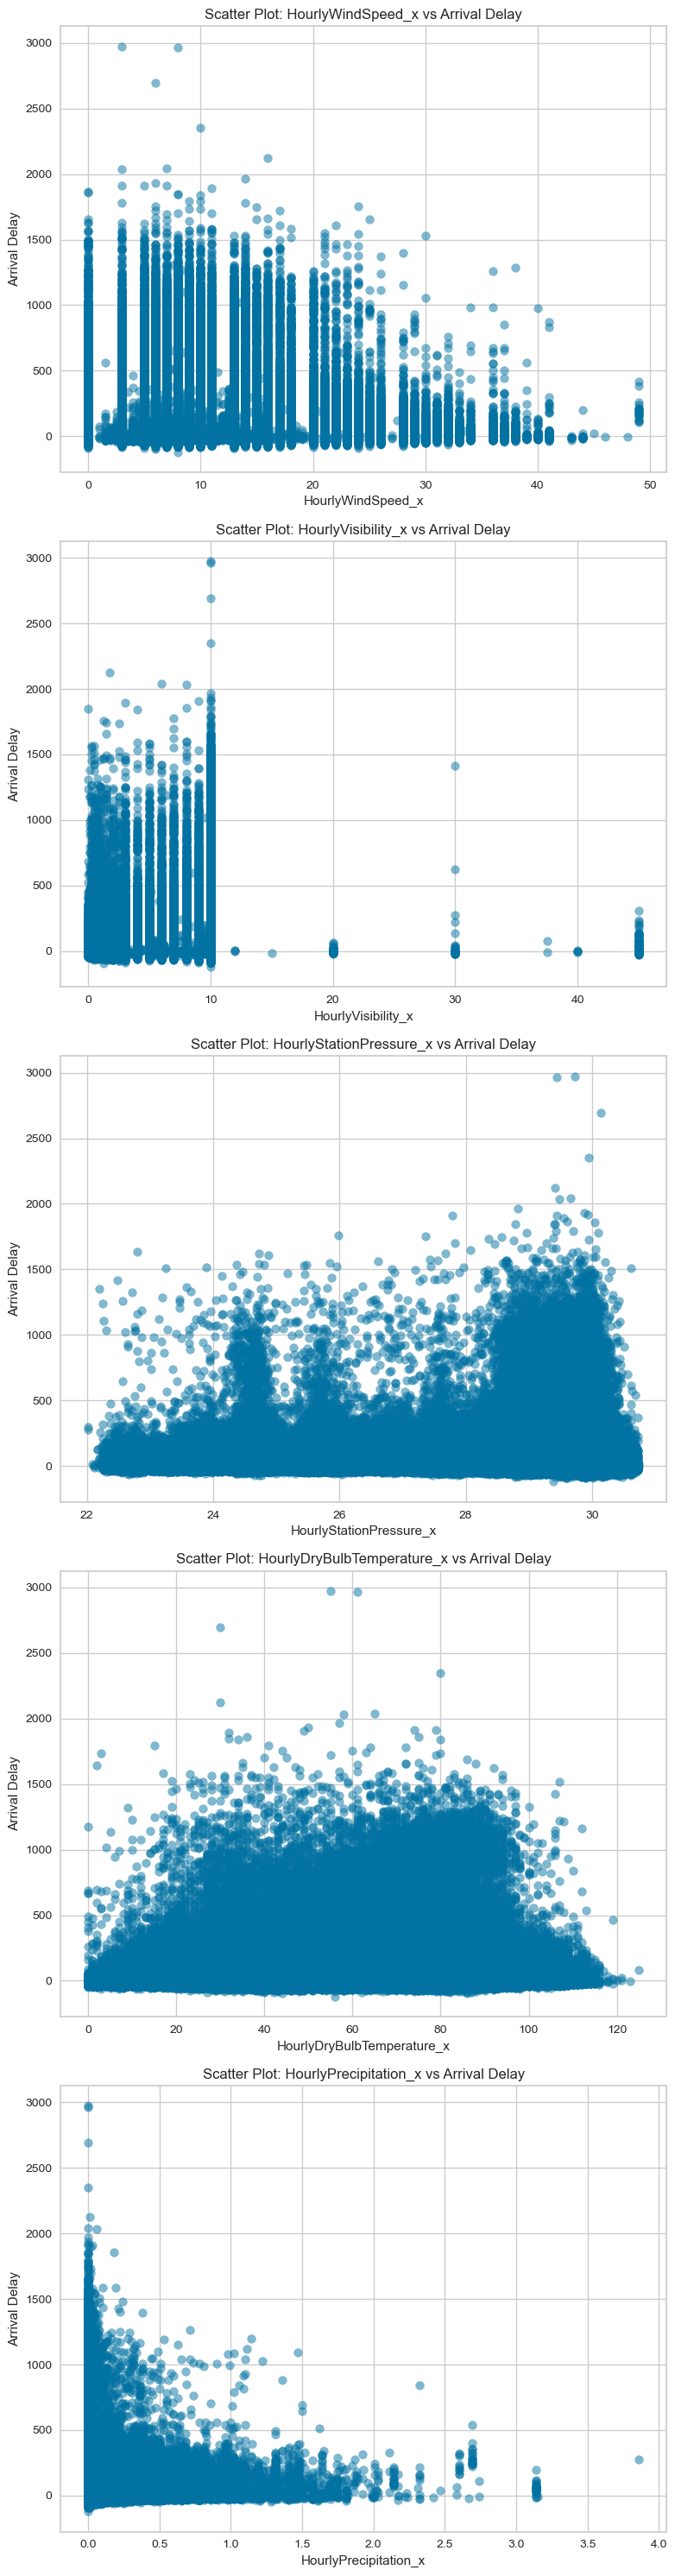

In [274]:
variables_to_plot = ['HourlyWindSpeed_x', 'HourlyVisibility_x', 'HourlyStationPressure_x', 'HourlyDryBulbTemperature_x', 'HourlyPrecipitation_x']

# Set up subplots
fig, axes = plt.subplots(nrows=len(variables_to_plot), ncols=1, figsize=(8, 6 * len(variables_to_plot)))

# Plot each variable in a separate subplot
for idx, variable in enumerate(variables_to_plot):
    ax = axes[idx]
    x_values = df_nocancel[variable]
    y_values = df_nocancel['arrival_delay']
    
    ax.scatter(x_values, y_values, alpha=0.5)
    
    # Set labels and title for each subplot
    ax.set_xlabel(variable)
    ax.set_ylabel('Arrival Delay')
    ax.set_title(f'Scatter Plot: {variable} vs Arrival Delay')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

Few notes on this. As can be seen from the plots, wind speed and visibility have some kind of influence in the arrival delay. There is some kind of tendency where, whenever the wind speed gets higher, it doesn't get higher delays but there is a significant number of delays.

In [275]:
origin_delays = df_nocancel[df_nocancel['departure_delay_categorised'] != 0][['origin_airport', 'departure_delay_categorised']].groupby('origin_airport').sum().sort_values(by='departure_delay_categorised', ascending=False)
origin_delays['PERCENTUAL'] = origin_delays['departure_delay_categorised']/(origin_delays['departure_delay_categorised'].sum())*100
origin_delays.head(15)

,departure_delay_categorised,PERCENTUAL
origin_airport,,
ORD,92976,6.197995
DFW,67606,4.506772
DEN,67203,4.479907
ATL,61554,4.103332
CLT,48047,3.202924
EWR,46978,3.131662
LAX,42816,2.854214
LGA,39654,2.643427
IAH,37570,2.504503


Top 15 airports with more departure delays

In [276]:
destination_delays = df_nocancel[df_nocancel['arrival_delay_categorised'] != 0][['destination_airport', 'arrival_delay_categorised']].groupby('destination_airport').sum().sort_values(by='arrival_delay_categorised', ascending=False)
destination_delays['PERCENTUAL'] = destination_delays['arrival_delay_categorised']/(destination_delays['arrival_delay_categorised'].sum())*100
destination_delays.head(15)


,arrival_delay_categorised,PERCENTUAL
destination_airport,,
ORD,99963,6.426488
DFW,66024,4.244595
DEN,63205,4.063365
EWR,56383,3.624788
ATL,56371,3.624017
LGA,48327,3.106879
SFO,44989,2.892283
LAX,41687,2.680002
CLT,40808,2.623492


Top 15 airports with more arrival delays

There are 363 airports in total but we'll keep the top 50 airports with more arrival delays to avoid high dimensionality. These airports should be the busiest as well

In [277]:
top_airports = destination_delays.index[:50]

df = df_nocancel[df_nocancel['destination_airport'].isin(top_airports)]
df.reset_index(drop=True, inplace=True)


In [294]:
df['actual_arrival_dt'] = pd.to_datetime(df['actual_arrival_dt']).dt.strftime('%H:%M:%S')
df['actual_departure_dt'] = pd.to_datetime(df['actual_departure_dt']).dt.strftime('%H:%M:%S')


/var/folders/sw/6xwmt9sn3gz0ynrs843r_b340000gn/T/ipykernel_12331/608819662.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual_arrival_dt'] = pd.to_datetime(df['actual_arrival_dt']).dt.strftime('%H:%M:%S')
/var/folders/sw/6xwmt9sn3gz0ynrs843r_b340000gn/T/ipykernel_12331/608819662.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual_departure_dt'] = pd.to_datetime(df['actual_departure_dt']).dt.strftime('%H:%M:%S')


## TRAINING FINAL MODEL

First I'll create a binary column for the arrival time where 0 will mean delays between 0 and 15 mins and 1 delays longer than 15 mins

In [295]:
df['arrival_delay_categorised_binary'] = np.where(df['arrival_delay_categorised'] == 0, 0, 1)
df['arrival_delay_categorised_binary'] = df['arrival_delay_categorised_binary'].astype('category')
df['departure_delay_categorised_binary'] = np.where(df['departure_delay_categorised'] == 0, 0, 1)
df['departure_delay_categorised_binary'] = df['departure_delay_categorised_binary'].astype('category')
df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.dayofweek.astype('category')
df['day_of_month'] = df['date'].dt.day.astype('category')
df['HourlyWindSpeed_x_categorised'] = df['HourlyWindSpeed_x_categorised'].astype('category')
df['HourlyVisibility_x_categorised'] = df['HourlyVisibility_x_categorised'].astype('category')
df['HourlyVisibility_x_categorised'] = df['HourlyVisibility_x_categorised'].astype('category')

base_final = df.copy()
base_final.drop(['actual_departure_dt','actual_arrival_dt','carrier_code'], inplace=True, axis=1)
base_final.set_index('month',inplace=True)

/var/folders/sw/6xwmt9sn3gz0ynrs843r_b340000gn/T/ipykernel_12331/2456215462.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['arrival_delay_categorised_binary'] = np.where(df['arrival_delay_categorised'] == 0, 0, 1)
/var/folders/sw/6xwmt9sn3gz0ynrs843r_b340000gn/T/ipykernel_12331/2456215462.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['arrival_delay_categorised_binary'] = df['arrival_delay_categorised_binary'].astype('category')
/var/folders/sw/6xwmt9sn3gz0ynrs843r_b340000gn/T/ipykernel_1233

In [296]:
target_final = base_final[['arrival_delay_categorised_binary']]


In [297]:
cat_vars_final = base_final.select_dtypes(['object','category'])
cat_vars_final = cat_vars_final.loc[:, ['day_of_week', 'day_of_month', 'departure_delay_categorised_binary', 'HourlyWindSpeed_x_categorised', 'HourlyVisibility_x_categorised']]


In [298]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder().fit(cat_vars_final)

In [299]:
cat_vars_ohe_final = enc.transform(cat_vars_final).toarray()
cat_vars_ohe_final = pd.DataFrame(cat_vars_ohe_final, index= cat_vars_final.index, 
                      columns=enc.get_feature_names_out(cat_vars_final.columns.tolist()))

In [300]:
target_may_oct_final = target_final.loc[(target_final.index >= 5) & (target_final.index <= 10)]
target_nov_dec_final = target_final.loc[(target_final.index >= 11) & (target_final.index <= 12)]

In [301]:
cat_vars_ohe_may_oct_final = cat_vars_ohe_final.loc[(cat_vars_ohe_final.index >= 5) & (cat_vars_ohe_final.index <= 10)]
cat_vars_ohe_nov_dec_final = cat_vars_ohe_final.loc[(cat_vars_ohe_final.index >= 11) & (cat_vars_ohe_final.index <= 12)]


In [302]:
from sklearn.linear_model import LogisticRegression

lr_model_final = LogisticRegression(C=1.0,n_jobs=-1,verbose=1, random_state=154)

#training
lr_model_final.fit(cat_vars_ohe_may_oct_final, target_may_oct_final)

/Users/jorgemartinez/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           47     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.18267D+06    |proj g|=  1.15041D+06


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   47     32     37      1     0     0   7.123D+00   7.895D+05
  F =   789511.92939707241     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.0min finished


LogisticRegression(n_jobs=-1, random_state=154, verbose=1)

## EVALUATION

In [303]:
from sklearn.model_selection import StratifiedKFold, cross_val_score,cross_val_predict # Cross Validation

In [304]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
result = cross_val_score(lr_model_final,cat_vars_ohe_may_oct_final,target_may_oct_final, cv=cv, scoring='roc_auc', n_jobs=-1)
print(f'Mean: {np.mean(result)}')
print(f'Inferior limit: {np.mean(result)-2*np.std(result)}')
print(f'Superior limit: {np.mean(result)+2*np.std(result)}')

/Users/jorgemartinez/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jorgemartinez/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jorgemartinez/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           47     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45511D+06    |proj g|=  7.66858D+05
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           47     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45511D+06    |proj g|=  7.66938D+05
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           47     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45511D+06    |proj g|=  7.67020D+05


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   47     32     37      1     0     0   3.474D+00   5.260D+05
  F =   526038.85292930075     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.4s finished



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   47     32     37      1     0     0   1.403D+00   5.267D+05
  F =   526670.75144972361     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished


Mean: 0.8865838240813654
Inferior limit: 0.8859579773715153
Superior limit: 0.8872096707912155


In [315]:
from sklearn.metrics import classification_report, roc_auc_score,precision_score,recall_score # Evaluating the Model

pred = lr_model_final.predict(cat_vars_ohe_nov_dec_final)
pred_prob = lr_model_final.predict_proba(cat_vars_ohe_nov_dec_final)

# print classification report
print("Classification relation:\n", 
       classification_report(target_nov_dec_final, pred, digits=4))

# print the area under the curve
print(f'AUC: {roc_auc_score(target_nov_dec_final,pred_prob[:,1])}')


Classification relation:
               precision    recall  f1-score   support

           0     0.9515    0.9546    0.9530    839245
           1     0.7767    0.7642    0.7704    173369

    accuracy                         0.9220   1012614
   macro avg     0.8641    0.8594    0.8617   1012614
weighted avg     0.9215    0.9220    0.9218   1012614

AUC: 0.8778305605169907


In [320]:
pred_prob.shape

(1012614, 2)

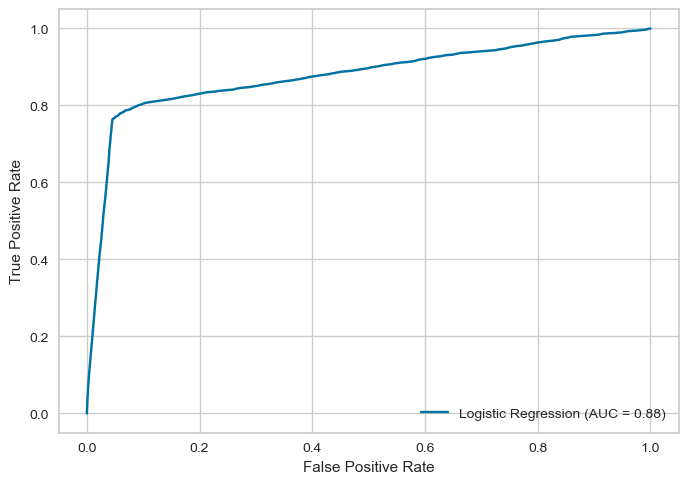

In [322]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from yellowbrick.classifier import ROCAUC
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(target_nov_dec_final, pred_prob[:,1])

roc_auc = metrics.roc_auc_score(target_nov_dec_final, pred_prob[:,1])

roc_display = RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc, estimator_name = 'Logistic Regression')
roc_display.plot()

/Users/jorgemartinez/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


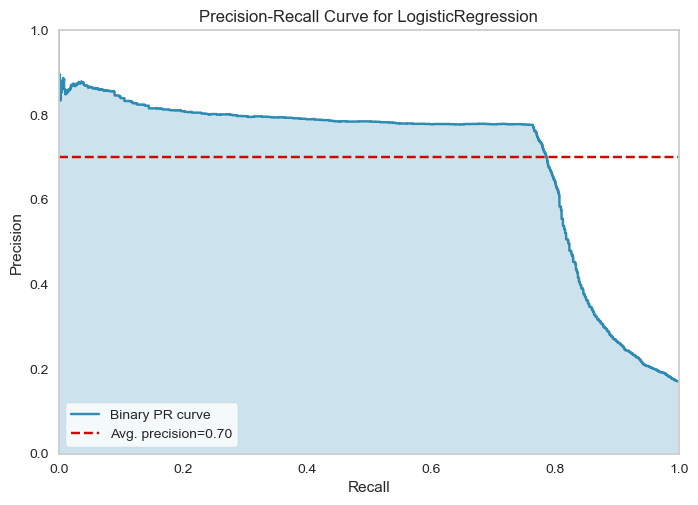

In [323]:
from yellowbrick.classifier import precision_recall_curve
viz = precision_recall_curve(lr_model_final, cat_vars_ohe_may_oct_final, target_may_oct_final, cat_vars_ohe_nov_dec_final, target_nov_dec_final)

